<a href="https://colab.research.google.com/github/Jionee/AI_colorization/blob/main/Image_Colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Colorization

##### Importing Library


In [1]:
import os
import cv2
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

##### Mounting Google Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Loading Image Dataset

In [3]:
train_path = './drive/MyDrive/testData'
test_path = './drive/MyDrive/testValidation'
final_test_path = './drive/MyDrive/finalTest'
evaluate_path = './drive/MyDrive/testEvaluate'
evaluate_number = 30

#Normalize images
test_datagen = train_datagen = finalTest_datagen = evaluate_datagen = ImageDataGenerator(rescale=1./255)
#Resize images, if needed
train = train_datagen.flow_from_directory(train_path, target_size=(256,256),batch_size=300,class_mode=None)
test = test_datagen.flow_from_directory(test_path, target_size=(256,256),batch_size=100,class_mode=None)
finalTest = finalTest_datagen.flow_from_directory(final_test_path, target_size=(256,256),batch_size=100,class_mode=None)
evaluateTest = evaluate_datagen.flow_from_directory(evaluate_path, target_size=(256,256),batch_size=evaluate_number,class_mode=None)

#Convert from RGB to LAB
def generateDataset(imgs):
  X = []
  Y = []
  for img in imgs[0]:
    try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128) #for normalize -1 to 1
    except:
      print('error')
  X = np.array(X)
  Y = np.array(Y)
  X = X.reshape(X.shape+(1,)) #X and Y dimension should be same
  return [X,Y]
  
[X_train,Y_train] = generateDataset(train)
[X_test,Y_test] = generateDataset(test)
[X_final_test,Y_final_test] = generateDataset(finalTest)
[X_evaluate_test,Y_evaluate_test] = generateDataset(evaluateTest)

Found 300 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


##### Constructing Model

In [4]:
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout,BatchNormalization
from keras.optimizers import Adam

inputs = Input(shape=(256,256,1))
x = inputs

# encoder

x = Conv2D(8, 3, padding='same')(x)
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(16, 3, padding='same',strides=2)(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x) 
#x = MaxPooling2D(2)(x)
x = Conv2D(16, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, 3, padding='same',strides=2)(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
#x = MaxPooling2D(2)(x)
x = Conv2D(64, 3, padding='same')(x)
x= BatchNormalization()(x)
x = Activation('relu')(x) 
x = Conv2D(64, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(128, 3, padding='same')(x)
x= BatchNormalization()(x)
x = Activation('relu')(x) 
x = Conv2D(256, 3, padding='same')(x)
x= BatchNormalization()(x)
x = Activation('relu')(x) 

# decoder
x = Conv2D(128, 3, padding='same')(x)
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D(2)(x)
x = Conv2D(64, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D(2)(x)
x = Conv2D(16, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(16, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D(2)(x)
x = Conv2D(2, 3, padding='same')(x) 
x= BatchNormalization()(x)
x = Activation('tanh')(x)

# x = Conv2D(8, 3, activation='relu', padding='same')(x)
# x = Conv2D(16, 3, activation='relu', padding='same')(x)  
# x = MaxPooling2D(2)(x)
# x = Conv2D(16, 3, activation='relu', padding='same')(x) 
# x = Conv2D(32, 3, activation='relu', padding='same')(x) 
# x = MaxPooling2D(2)(x)
# x = Conv2D(64, 3, activation='relu', padding='same')(x) 
# x = Conv2D(64, 3, activation='relu', padding='same')(x) 
# x = MaxPooling2D(2)(x)
# x = Conv2D(128, 3, activation='relu', padding='same')(x) 
# x = Conv2D(256, 3, activation='relu', padding='same')(x) 

# # decoder
# x = Conv2D(128, 3, activation='relu', padding='same')(x)
# x = Conv2D(64, 3, activation='relu', padding='same')(x) 
# x = UpSampling2D(2)(x)
# x = Conv2D(64, 3, activation='relu', padding='same')(x) 
# x = Conv2D(32, 3, activation='relu', padding='same')(x) 
# x = UpSampling2D(2)(x)
# x = Conv2D(16, 3, activation='relu', padding='same')(x) 
# x = Conv2D(16, 3, activation='relu', padding='same')(x) 
# x = UpSampling2D(2)(x)
# x = Conv2D(2, 3, activation='tanh', padding='same')(x) 
# x= BatchNormalization()(x)

outputs = x
model = Model(inputs, outputs)
LEARNING_RATE = 0.0001
model.compile(optimizer=Adam(lr=LEARNING_RATE), loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 8)       80        
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0     

##### Model Training

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('./drive/MyDrive/test/bestModel17.model', monitor='val_loss', mode='min',verbose=1, save_best_only=True)

fitModel = model.fit(X_train,Y_train, epochs=700, batch_size=20, validation_data=(X_test,Y_test))#,callbacks=[es,mc])



Epoch 1/700
15/15 [==============================] - 2s 113ms/step - loss: 0.0147 - accuracy: 0.6204 - val_loss: 0.0119 - val_accuracy: 0.6155
Epoch 2/700
15/15 [==============================] - 2s 107ms/step - loss: 0.0147 - accuracy: 0.6260 - val_loss: 0.0124 - val_accuracy: 0.6217
Epoch 3/700
15/15 [==============================] - 2s 108ms/step - loss: 0.0173 - accuracy: 0.6346 - val_loss: 0.0270 - val_accuracy: 0.6019
Epoch 4/700
15/15 [==============================] - 2s 108ms/step - loss: 0.0164 - accuracy: 0.6105 - val_loss: 0.0123 - val_accuracy: 0.6169
Epoch 5/700
15/15 [==============================] - 2s 108ms/step - loss: 0.0149 - accuracy: 0.6200 - val_loss: 0.0122 - val_accuracy: 0.6313
Epoch 6/700
15/15 [==============================] - 2s 108ms/step - loss: 0.0144 - accuracy: 0.6283 - val_loss: 0.0119 - val_accuracy: 0.6293
Epoch 7/700
15/15 [==============================] - 2s 108ms/step - loss: 0.0137 - accuracy: 0.6402 - val_loss: 0.0118 - val_accuracy: 0.6290

##### Plotting Accuracy


In [ ]:
'''
def visModel():
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.plot(fitModel.history['accuracy'])
  plt.plot(fitModel.history['val_accuracy'])
  plt.legend(['training', 'validation'], loc = 'upper left')
  plt.show()
'''
def visLoss():
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.plot(fitModel.history['loss'])
  plt.plot(fitModel.history['val_loss'])
  plt.legend(['loss','val_loss'], loc = 'upper left')
  plt.show()

def visAccuracy():
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.plot(fitModel.history['accuracy'])
  plt.plot(fitModel.history['val_accuracy'])
  plt.legend(['accuracy', 'val_accuracy'], loc = 'upper left')
  plt.show()


##### Model Save & Caculating Accuracy

4/4 [==============================] - 0s 71ms/step - loss: 0.0127 - accuracy: 0.5436
Test accuracy:  [0.012686114758253098, 0.5435941815376282]


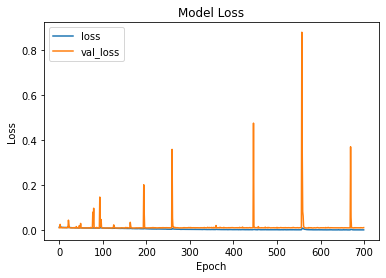

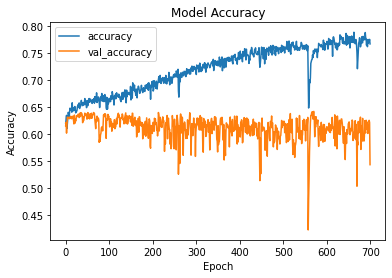

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./drive/MyDrive/test/model18.model/assets


In [ ]:
#model_accuracy
results = model.evaluate(X_test, Y_test)

print('Test accuracy: ', results)

#visualization Model
visLoss()
visAccuracy()

#save
modelPath = './drive/MyDrive/test/model18.model'
model.save(modelPath)

##### PSNR 

In [ ]:
import math
import numpy

# def calPSNR (img1,img2):
#   mse=numpy.mean((img1-img2)**2)
#   if mse==0:
#     return 100
#   PIXEL_MAX=255.0
#   return 20*math.log10(PIXEL_MAX/math.sqrt(mse))

  # 케라스 psnr 평가 metric 예시
def calPSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)




##### Result Images

/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 10 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.6/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


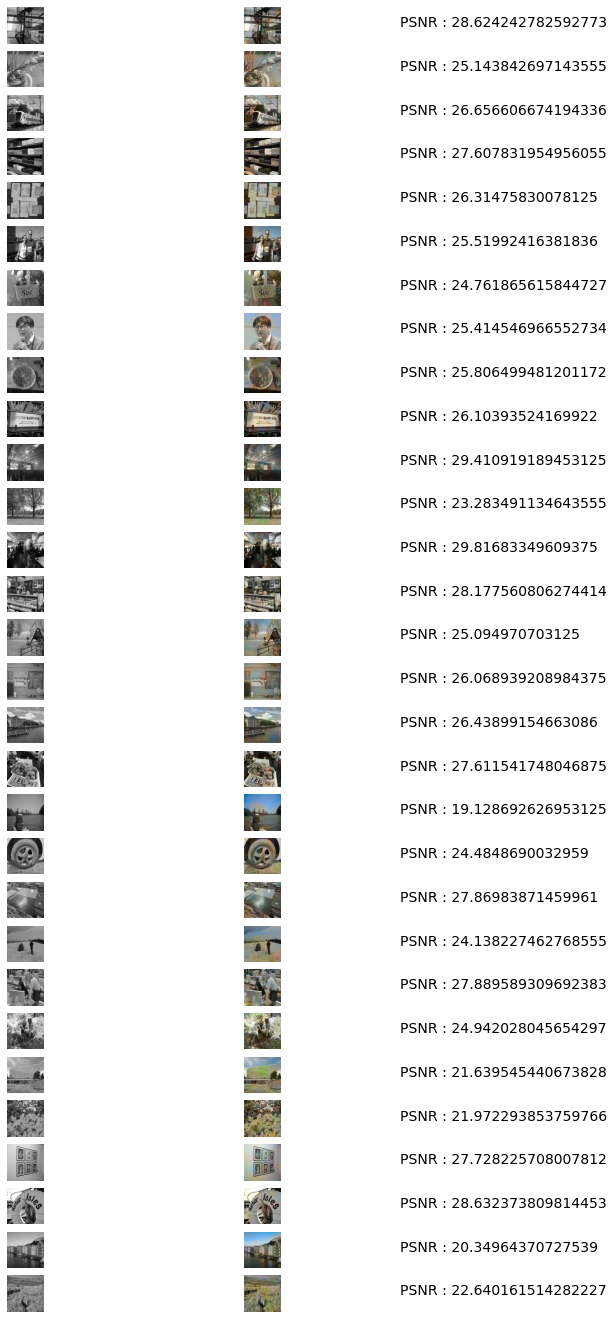

In [ ]:
modelPath = './drive/MyDrive/test/model1.model'
#modelPath = '/content/drive/MyDrive/test/bestModel17.model'
model = tf.keras.models.load_model(
    modelPath,
    custom_objects=None,
    compile=True
)

#==========================final_test===================================
# output = model.predict(X_final_test)
# output = output*128 # (1, 256, 256, 2)

# result = np.zeros((100,256,256,3))
# result[:,:,:,0] = X_final_test[:,:,:,0] #L
# result[:,:,:,1:] = output#AB
# pred_Imgs = [lab2rgb(result[i]) for i in range(100)]

# storePath="./drive/MyDrive/result/num"

# plt.figure(figsize=(12,24))
# plt.title("Test vs Predicted Test")
# i=1
# j=0
# for j in range(10):
#   plt.subplot(10,3,i)
#   plt.axis('off')
#   plt.imshow(finalTest[0][j])
#   plt.subplot(10,3,i+1)
#   plt.axis('off')
#   plt.imshow(pred_Imgs[j])
#   #plt.imshow(Y_test[0])
#   plt.subplot(10,3,i+2)
#   plt.axis('off')

#   #PSNR = calPSNR(finalTest[0], pred_Imgs)
#   PSNR = calPSNR(finalTest[0][j],pred_Imgs[j])
#   plt.text(0,0.45,f"PSNR : {PSNR}",fontsize=14)
#   i += 3

#==========================test===================================

# output = model.predict(X_test)
# output = output*128 # (1, 256, 256, 2)

# result = np.zeros((100,256,256,3))
# result[:,:,:,0] = X_test[:,:,:,0] #L
# #result[:,:,:,1:] = Y_test[:,:,:,0:] *128 #AB
# #result[:,:,:,1] = Y_test[:,:,:,0] *128 #AB
# # result[:,:,:,2] = Y_test[:,:,:,1] *128 #AB
# #result[:,:,:,1] = output[:,:,:,0] *128 #AB
# #result[:,:,:,2] = output[:,:,:,1] *128 #AB
# result[:,:,:,1:] = output#AB
# pred_Imgs = [lab2rgb(result[i]) for i in range(100)]
# # imsave("result.png",lab2rgb(result))

# plt.figure(figsize=(12,24))
# plt.title("Test vs Predicted Test")
# i=1
# j=0
# for j in range(10):
#   #j=j+1
#   #j = np.random.randint(0,99)
#   plt.subplot(10,3,i)
#   plt.axis('off')
#   plt.imshow(test[0][j])
#   plt.subplot(10,3,i+1)
#   plt.axis('off')
#   plt.imshow(pred_Imgs[j])
#   #plt.imshow(Y_test[0])
#   plt.subplot(10,3,i+2)
#   plt.axis('off')

#   PSNR = calPSNR(test[0][j],pred_Imgs[j])
#   plt.text(0,0.45,f"PSNR : {PSNR}",fontsize=14)
#   i += 3
#   j += 1
#==========================train===================================

# output = model.predict(X_train)
# output = output*128 # (1, 256, 256, 2)

# result = np.zeros((300,256,256,3))
# result[:,:,:,0] = X_train[:,:,:,0] #L
# result[:,:,:,1:] = output#AB
# pred_Imgs = [lab2rgb(result[i]) for i in range(300)]
# # imsave("result.png",lab2rgb(result))

# plt.figure(figsize=(6,12))
# plt.title("Test vs Predicted Test")
# i=1
# for j in range(5):
#   #j=j
#   j = np.random.randint(0,99)
#   plt.subplot(5,3,i)
#   plt.axis('off')
#   plt.imshow(train[0][j])
#   plt.subplot(5,3,i+1)
#   plt.axis('off')
#   plt.imshow(pred_Imgs[j])
#   plt.subplot(5,3,i+2)
#   plt.axis('off')

#   PSNR = calPSNR(train[0][j],pred_Imgs[j])
#   plt.text(0,0.45,f"PSNR : {PSNR}",fontsize=14)
#   i += 3
  
#==========================Evaluate_test===================================
output = model.predict(X_evaluate_test)
output = output*128 # (1, 256, 256, 2)

result = np.zeros((evaluate_number,256,256,3))
result[:,:,:,0] = X_evaluate_test[:,:,:,0] #L
result[:,:,:,1:] = output#AB
pred_Imgs = [lab2rgb(result[i]) for i in range(evaluate_number)]

storePath="./drive/MyDrive/result/"
for k in range(evaluate_number):
  imsave(storePath+str(k)+'.png',pred_Imgs[k])

plt.figure(figsize=(12,24))
plt.title("Test vs Predicted Test")
i=1
j=0
for j in range(evaluate_number):
  
  #j = np.random.randint(0,evaluate_number-1)
  plt.subplot(evaluate_number,3,i)
  plt.axis('off')
  plt.imshow(evaluateTest[0][j])
  plt.subplot(evaluate_number,3,i+1)
  plt.axis('off')
  plt.imshow(pred_Imgs[j])
  plt.subplot(evaluate_number,3,i+2)
  plt.axis('off')

  PSNR = calPSNR(evaluateTest[0][j],pred_Imgs[j])
  plt.text(0,0.45,f"PSNR : {PSNR}",fontsize=14)
  i += 3
  j += 1

In [ ]:
def AveragePSNR(pred_Imgs, test):
  psnr = 0.0
  for i in range(len(pred_Imgs)):
    psnr += calPSNR(pred_Imgs[i],test[i])
  print(f"Average PSNR : {psnr/len(pred_Imgs)}") 

AveragePSNR(pred_Imgs, evaluateTest[0])
#AveragePSNR(pred_Imgs, finalTest[0])
#AveragePSNR(pred_Imgs, test[0])
#AveragePSNR(pred_Imgs, train[0])

Average PSNR : 28.21949005126953
